In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os, cv2
from tqdm import tqdm
import tensorflow as tf
seed = 2022
tf.random.set_seed(seed)
np.random.seed(seed)
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Embedding, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

### 1. 리사이즈, 선 따기 후 데이터셋까지 저장

- 리사이즈 데이터 저장

In [ ]:
'''
images 폴더 아래 raw는 리사이즈 전 사진들이 모여있다
resized 폴더에 리사이즈 전 사진들을 (128, 128)로 맞춘 이미지를
캐릭터 이름별 폴더를 만들어 저장한다
'''

img_path = "C:/workspace/04.SecondProject/images"
cha_list = os.listdir(f'{img_path}/raw_img')
for idx, img_cha in enumerate(cha_list):
    filepath = f"{img_path}/raw_img/{img_cha}"
    for fname in os.listdir(filepath):
        img = cv2.imread(f'{filepath}/{fname}', cv2.IMREAD_COLOR)
        resize_img = cv2.resize(img, dsize=(128, 128), interpolation= cv2.INTER_LINEAR)
        try:
            if not os.path.exists(f'{img_path}/resized/{img_cha}'):
                os.mkdir(f'{img_path}/resized/{img_cha}')
            cv2.imwrite(f'{img_path}/resized/{img_cha}/{fname}', resize_img)
        except:
            print(fname)
            continue
        

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
img = load_img("C:/workspace/04.SecondProject/images/resized/leeseul/leeseul (4).jpg")
x = img_to_array(img)
x.shape

(128, 128, 3)

- 선만 딴 사진 저장

In [ ]:
'''
라인 따서 저장
'''

img_path = "C:/workspace/04.SecondProject/images"
cha_list = os.listdir(f'{img_path}/resized')
for img_cha in cha_list:
    filepath = f"{img_path}/resized/{img_cha}"
    for fname in os.listdir(filepath):
        img = cv2.imread(f'{filepath}/{fname}', cv2.IMREAD_COLOR)
        blur = cv2.GaussianBlur(img, ksize = (3,3), sigmaX = 0)
        edged = cv2.Canny(blur, 100, 200)
        
        
        
        try:
            if not os.path.exists(f'{img_path}/edged/{img_cha}'):
                os.mkdir(f'{img_path}/edged/{img_cha}')
            cv2.imwrite(f'{img_path}/edged/{img_cha}/{fname}', edged)
        except:
            print(fname)
            continue

- 데이터셋 분리

In [ ]:
img_path = "c:/workspace/04.SecondProject/images/edged"
splitfolders.ratio(img_path, output=img_path+'/split', seed=2022, ratio=(.8, 0.1, 0.1))
import splitfolders

Copying files: 1449 files [00:04, 335.79 files/s]


### 2. 모델

- 부풀리기

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.5,
    zoom_range=[0.8,1.2],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

In [10]:
img = load_img('C:/workspace/04.SecondProject/images/edged/split/train/evee/evee (1).jpg')
x = img_to_array(img)
x.shape

(128, 128, 3)

In [11]:
#x.reshape(1, 24, 24, 3)
x = x.reshape((1,) + x.shape)
x.shape

(1, 128, 128, 3)

In [12]:
import os
if not os.path.exists('preview'):
    os.mkdir('preview')
count = 0
for _ in train_datagen.flow(x, batch_size=1, save_to_dir='./preview', save_prefix='pre'):
    count += 1
    if count >= 30:
        break

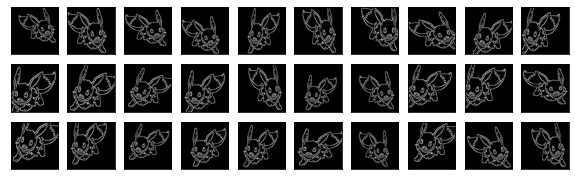

In [14]:
plt.figure(figsize=(10,3))
for i, fname in enumerate(glob('preview/*.png')):
    img = Image.open(fname)
    plt.subplot(3, 10, i+1)
    plt.imshow(img), plt.xticks([]), plt.yticks([])
plt.show()

In [15]:
img_path = "c:/workspace/04.SecondProject/images/edged"
train_data_generator = train_datagen.flow_from_directory(
    f'{img_path}/split/train', target_size=(128,128),
    batch_size=3, class_mode='categorical'
)
test_datagen = ImageDataGenerator(rescale=1/255.)
test_data_generator = test_datagen.flow_from_directory(
    f'{img_path}/split/test', target_size=(128,128),
    batch_size=3, class_mode='categorical'
)

- 모델 정의

In [7]:
model = Sequential([
    Conv2D(32, (3,3), input_shape=(128,128,3), padding = 'same', activation='relu'),
    Conv2D(32, (3,3),activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(64, (3,3), padding = 'same', activation='relu'),
    Conv2D(64, (3,3),activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(128, (3,3), padding = 'same', activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(8, activation='softmax'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [8]:
model.compile('adam','categorical_crossentropy',['accuracy'])

In [9]:
model_path = './Last_best_adam.h5'
mc = ModelCheckpoint(model_path, moniter = 'accuracy', verbose = 0, save_best_only = True)
es = EarlyStopping(patience = 100)

In [10]:
# step_per_epoch 몇으로 할지 train 이미지를 validation_steps로 나눔
1155/15

77.0

In [11]:
with tf.device(device_name="GPU:0"):
    hist = model.fit(
    train_data_generator, steps_per_epoch=77, epochs=500,
    validation_data=test_data_generator, validation_steps=15,
    callbacks=[mc, es]
)

Epoch 1/500
77/77 [==============================] - 4s 13ms/step - loss: 2.0886 - accuracy: 0.1515 - val_loss: 2.0708 - val_accuracy: 0.1333
Epoch 2/500
77/77 [==============================] - 1s 11ms/step - loss: 2.0560 - accuracy: 0.1602 - val_loss: 2.0264 - val_accuracy: 0.1556
Epoch 3/500
77/77 [==============================] - 1s 11ms/step - loss: 2.0501 - accuracy: 0.2035 - val_loss: 1.9389 - val_accuracy: 0.2667
Epoch 4/500
77/77 [==============================] - 1s 11ms/step - loss: 2.0176 - accuracy: 0.2121 - val_loss: 1.9854 - val_accuracy: 0.1778
Epoch 5/500
77/77 [==============================] - 1s 11ms/step - loss: 2.0281 - accuracy: 0.1818 - val_loss: 2.0931 - val_accuracy: 0.1333
Epoch 6/500
77/77 [==============================] - 1s 11ms/step - loss: 2.0540 - accuracy: 0.1645 - val_loss: 2.0299 - val_accuracy: 0.1111
Epoch 7/500
77/77 [==============================] - 1s 11ms/step - loss: 2.0595 - accuracy: 0.1429 - val_loss: 1.9769 - val_accuracy: 0.3333
Epoch 

In [19]:
model_path = './New_adam.h5'
best_model = load_model(model_path)
best_model.evaluate(test_data_generator)

51/51 [==============================] - 1s 3ms/step - loss: 0.5572 - accuracy: 0.8954


[0.5571977496147156, 0.8954248428344727]

- 학습과정 시각화

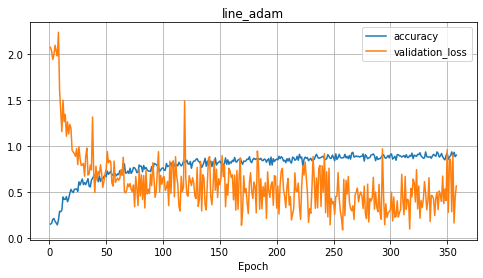

In [14]:
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (8, 4))
plt.plot(xs, y_acc, label = 'accuracy')
plt.plot(xs, y_vloss, label = 'validation_loss')
plt.xlabel('Epoch')
plt.title('line_adam')
plt.legend(), plt.grid()
plt.show()

### 3. 결과보기

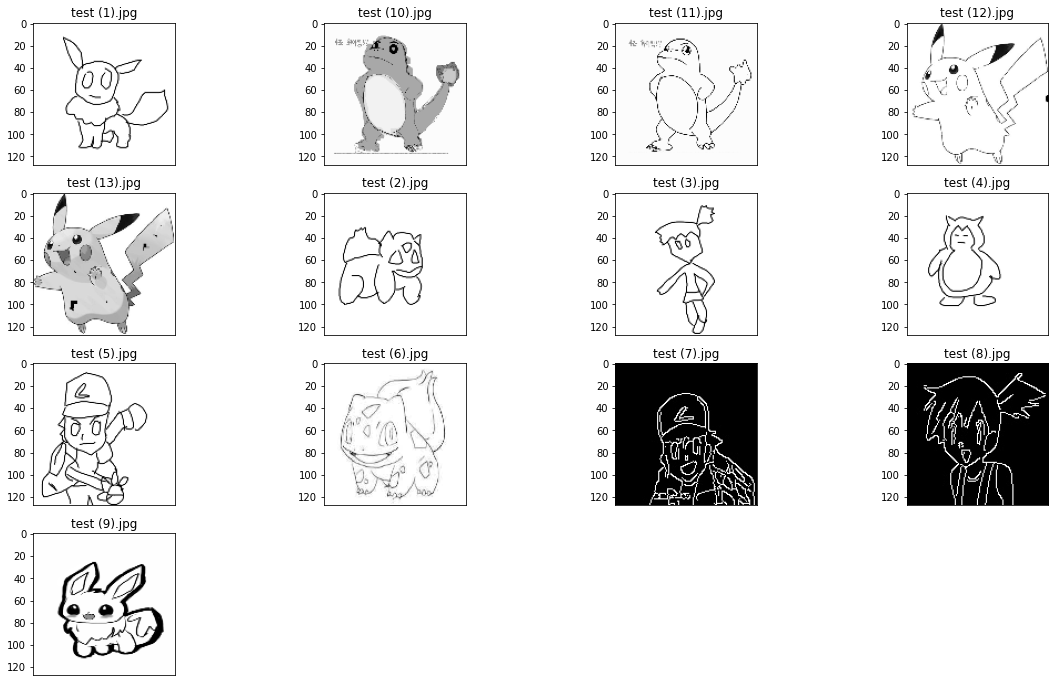

In [23]:
test = os.listdir('C:/workspace/04.SecondProject/images/test_hand_draw')
path = "C:/workspace/04.SecondProject/images/test_hand_draw"
plt.figure(figsize = (20, 12))
for idx, i in enumerate(test):
    img = cv2.imread(f'{path}/{i}', cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128), cv2.INTER_LINEAR)
    plt.subplot(4, 4, idx+1)
    plt.title(i)
    plt.xticks([]), #plt.yticks([])
    plt.imshow(img, cmap='gray')


In [3]:
model_path = './New_adam.h5'
best_model = load_model(model_path)

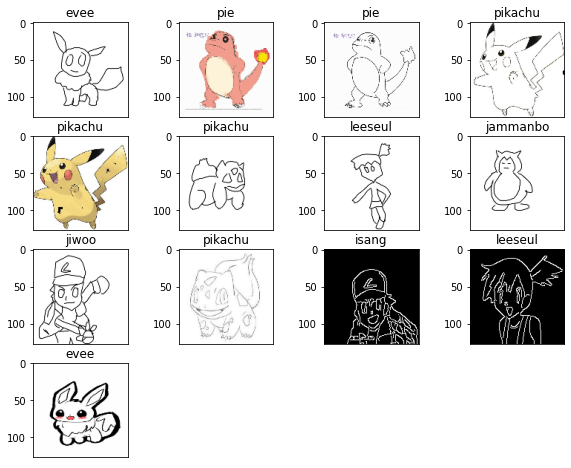

In [22]:
categories =['evee', 'isang', 'jammanbo', 'jiwoo', 'leeseul', 'pie', 'pikachu', 'squirtle']
test = os.listdir('C:/workspace/04.SecondProject/images/test_hand_draw')
path = "C:/workspace/04.SecondProject/images/test_hand_draw"
img_path = "C:/workspace/04.SecondProject/images"
plt.figure(figsize = (10, 8))
for idx, i in enumerate(test):
    img_o = cv2.imread(f'{path}/{i}')
    img_o = cv2.cvtColor(img_o, cv2.COLOR_BGR2RGB)
    img_o = cv2.resize(img_o, (128, 128))
    blur = cv2.GaussianBlur(img_o, ksize = (5,5), sigmaX = 0)
    edged = cv2.Canny(blur, 100, 200)
    try:
            if not os.path.exists(f'{img_path}/test'):
                os.mkdir(f'{img_path}/test')
            cv2.imwrite(f'{img_path}/test/{test}', edged)
    except:
        print(fname)
        continue
    cv2.imwrite(f'C:/workspace/04.SecondProject/images/test/{test}', edged)
    img = load_img(f'C:/workspace/04.SecondProject/images/test/{test}')
    x = img_to_array(img)
    
    arr_img = x.reshape(-1, 128, 128, 3)
    pred = best_model.predict(arr_img/255.)
    label = pred[0].argmax()
    prob = pred[0][label]
    pokemon = categories[label]
    plt.subplot(4, 4, idx+1)
    plt.title(pokemon)
    plt.xticks([])
    plt.imshow(img_o)

선 딴 이미지를 저장하지 않고 reshape 하는 방법이 필요

대안1:

edges = cv2.Canny(blur, 10, 200)

img_edges.append(np.expand_dims(edges, axis=-1))

img_edges = np.array(img_edges) / 127.5 - 1.